## Data Preparation and Baseline

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# For reproducibility, we'll create a sample DataFrame, same as for Chapter 3
dates = pd.date_range('2019-01-01', '2023-12-31', freq='D')
np.random.seed(42)
trend = np.linspace(50, 80, len(dates))
seasonal = 10 * np.sin(2 * np.pi * np.arange(len(dates)) / 365.25)
noise = np.random.normal(0, 5, len(dates))
y = pd.Series(trend + seasonal + noise, index=dates, name="value")

# The baseline score to beat from Chapter 3
ARIMA_MASE = 0.85 
print(f"Target to beat: AutoARIMA MASE = {ARIMA_MASE:.2f}")

Target to beat: AutoARIMA MASE = 0.85


## Feature Engineering

In [2]:
def create_features(y):
    """Creates time series features from a pandas Series."""
    X = pd.DataFrame(index=y.index)
    X['day_of_week'] = y.index.dayofweek
    X['is_weekend'] = (X['day_of_week'] >= 5).astype(int)
    X['lag_1'] = y.shift(1)
    
    # Drop the day_of_week column as it's redundant now
    X = X.drop(columns=['day_of_week'])
    return X

# Create the feature matrix
X = create_features(y)

# Align X and y by dropping the first row that has a NaN value
Xy = pd.concat([y, X], axis=1).dropna()
y = Xy['value']
X = Xy.drop(columns=['value'])

print("Feature Matrix X (first 5 rows):")
print(X.head())

Feature Matrix X (first 5 rows):
            is_weekend      lag_1
2019-01-02           0  52.483571
2019-01-03           0  49.497133
2019-01-04           0  53.615300
2019-01-05           1  58.180308
2019-01-06           1  49.582541


## Model Training Setup

In [3]:
from sktime.split import SlidingWindowSplitter
from sklearn.ensemble import RandomForestRegressor

# Define our model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Define our temporal cross-validation strategy
# We use 5 splits to get a robust estimate of performance
cv = SlidingWindowSplitter(window_length=50, step_length=12, fh=1)

## Prediction Loop (Backtesting)

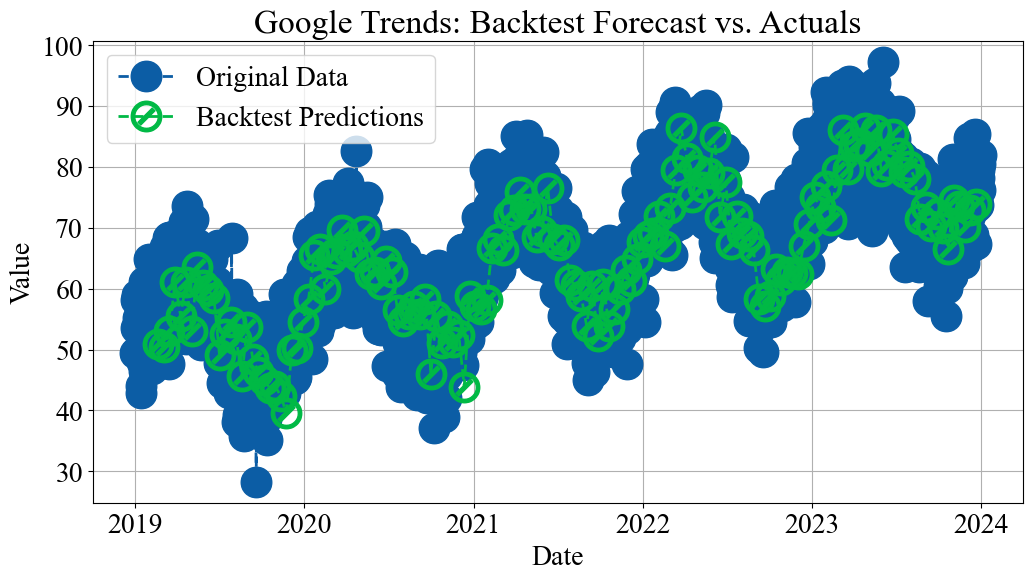

In [4]:
# Store out-of-sample predictions from each fold
all_predictions = []
all_true_values = []
all_test_indices = []

for train_index, test_index in cv.split(y):
    # Get the data for this split
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    preds = model.predict(X_test)
    
    # Store results
    all_predictions.extend(preds)
    all_true_values.extend(y_test.values)
    all_test_indices.extend(test_index)

# Create a DataFrame for plotting results
results_df = pd.DataFrame({
    'true_values': all_true_values,
    'predictions': all_predictions
}, index=y.index[all_test_indices])

# Plot the backtest predictions against the original data 
plt.figure(figsize=(12, 6))
plt.plot(y, label='Original Data')
plt.plot(results_df['predictions'], label='Backtest Predictions', linestyle='--')
plt.title('Google Trends: Backtest Forecast vs. Actuals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Validation

In [5]:
# Calculate the metrics
mae = mean_absolute_error(all_true_values, all_predictions)
rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))

# For MASE, the naive forecast is the previous value
naive_mae = mean_absolute_error(y.iloc[1:], y.iloc[:-1])
mase = mae / naive_mae

print("--- ML Model Performance ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MASE: {mase:.2f}")

print("\n--- Baseline Performance ---")
print(f"AutoARIMA MASE: {ARIMA_MASE:.2f}")

if mase < ARIMA_MASE:
    print("\nResult: The Random Forest model beat the ARIMA baseline!")
else:
    print("\nResult: The ARIMA baseline was better or equal.")


--- ML Model Performance ---
MAE:  5.06
RMSE: 6.11
MASE: 0.90

--- Baseline Performance ---
AutoARIMA MASE: 0.85

Result: The ARIMA baseline was better or equal.
